In [1]:
#all the imports
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

In [2]:
#read path and filenames from json
import json
with open('private.json', 'r') as fp:
    data = json.load(fp)
    
#
path = data["path"]
chosen_csv = data["chosen-csv"]

In [3]:
#read the clean data
flies = pd.read_csv(path + chosen_csv, index_col = 0)

In [4]:
#flies.shape
flies.columns

Index(['anglesub', 'nflies_close', 'conditioning', 'velmag', 'Chain', 'Chase',
       'dcenter', 'Grooming'],
      dtype='object')

In [5]:
flies_dummies = pd.get_dummies(flies, prefix = '', prefix_sep = '')

In [6]:
flies_dummies.head()

,anglesub,nflies_close,velmag,Chain,Chase,dcenter,Grooming,Grouped,Grouped_Starved,Males_Grouped_and_Female,Mated,Rejected,Single
1814,-0.053073,-0.277503,0.954409,0.051440,0.245776,1.246561,-1.273405,0,0,0,0,1,0
828,-0.543977,0.612238,0.275710,0.376675,-0.433725,-0.180969,-0.544525,1,0,0,0,0,0
1412,0.407945,-0.253148,0.171013,-0.117531,0.841493,-0.476560,-0.204454,0,0,0,0,0,1
386,-0.810580,-0.631007,-0.098685,-0.659609,-0.351079,0.568173,-0.121123,1,0,0,0,0,0
699,-0.488563,-0.390908,-0.659317,-0.681530,-0.537602,-0.555598,0.958214,1,0,0,0,0,0


In [7]:
def model_scatter(model, X_train, X_test, y_train, y_test, caption, ax):
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test  = sqrt(mean_squared_error(y_test, y_test_pred))

    r2_train = r2_score(y_train, y_train_pred)
    r2_test  = r2_score(y_test, y_test_pred)
    
    print(f"{caption}\n\trmse/r2 train =  {rmse_train:}/{r2_train}\n\trmse/r2 test =  {rmse_test}/{r2_test}")

    train = pd.DataFrame({"y" : y_train, "y_pred" : y_train_pred})
    train["label"] = "train"  

    test = pd.DataFrame({"y" : y_test, "y_pred" : y_test_pred})
    test["label"] = "test"
    
    df = pd.concat([train, test])
    sns.scatterplot(data = df, x = "y", y = "y_pred", hue = "label", ax = ax).set(title = caption)

In [8]:
def regression(score : str, trainsize : float= 0.7, dominant_count : int = 3, laso_alpha : float = 0.01, scatter_plot : bool = True):

    #start pipeline
    X = flies_dummies.drop([score], axis = 1)
    y = flies_dummies[score]

    #Splitting to Test/Train
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = trainsize, random_state = 0)

    #Testing with Lasso
    lasso = Lasso(alpha = laso_alpha).fit(X_train, y_train)
    abs_coef = np.abs(lasso.coef_)
    coef_index = np.argsort(abs_coef)
    print(f"Lasso |Coefs|:\n{abs_coef}\n{coef_index}")    
    
    #selecting only the dominant features
    keep_columns = set()
    for i in range(dominant_count):
        keep_columns.add(X_test.columns[-i])
    print(f"Selecting {dominant_count} Columns:\n{keep_columns}")
    drop_columns = set(X_test.columns.tolist()) - keep_columns
    #print(f"Dropping Columns:\n{drop_columns}")
    X_train = X_train.drop(drop_columns, axis = 1)
    X_test = X_test.drop(drop_columns, axis = 1)

    lr = LinearRegression().fit(X_train, y_train)    
    knr = KNeighborsRegressor(n_neighbors = dominant_count).fit(X_train, y_train)
    dtr = DecisionTreeRegressor().fit(X_train, y_train) #max_depth = dominant_count

    if scatter_plot:

        fig, ax = plt.subplots(3, 1, figsize = (20, 20))

        #Linear Regression Fitting
        model_scatter(lr, X_train, X_test, y_train, y_test, "Linear Regression", ax[0])        

        #KNN Fitting
        model_scatter(knr, X_train, X_test, y_train, y_test, "K Neighbors Regression", ax[1])

        #Descision tree
        model_scatter(dtr, X_train, X_test, y_train, y_test, "Decision Tree Regression", ax[2])
    
    return (lr, knr, dtr, list(keep_columns))

Lasso |Coefs|:
[0.         0.0363539  0.74851525 0.         0.         0.07178158
 0.03655379 0.         0.         0.24482955 0.         0.        ]
[ 0  3  4  7  8 10 11  1  6  5  9  2]
Selecting 3 Columns:
{'Rejected', 'Single', 'anglesub'}
Linear Regression
	rmse/r2 train =  0.883933232526269/0.22740671499770782
	rmse/r2 test =  0.8709575455481864/0.22063761634797452
K Neighbors Regression
	rmse/r2 train =  0.6974261259154279/0.519040586239687
	rmse/r2 test =  0.9683326139741804/0.03662674085800577
Decision Tree Regression
	rmse/r2 train =  0.0/1.0
	rmse/r2 test =  1.1741558466051936/-0.41643600715557505


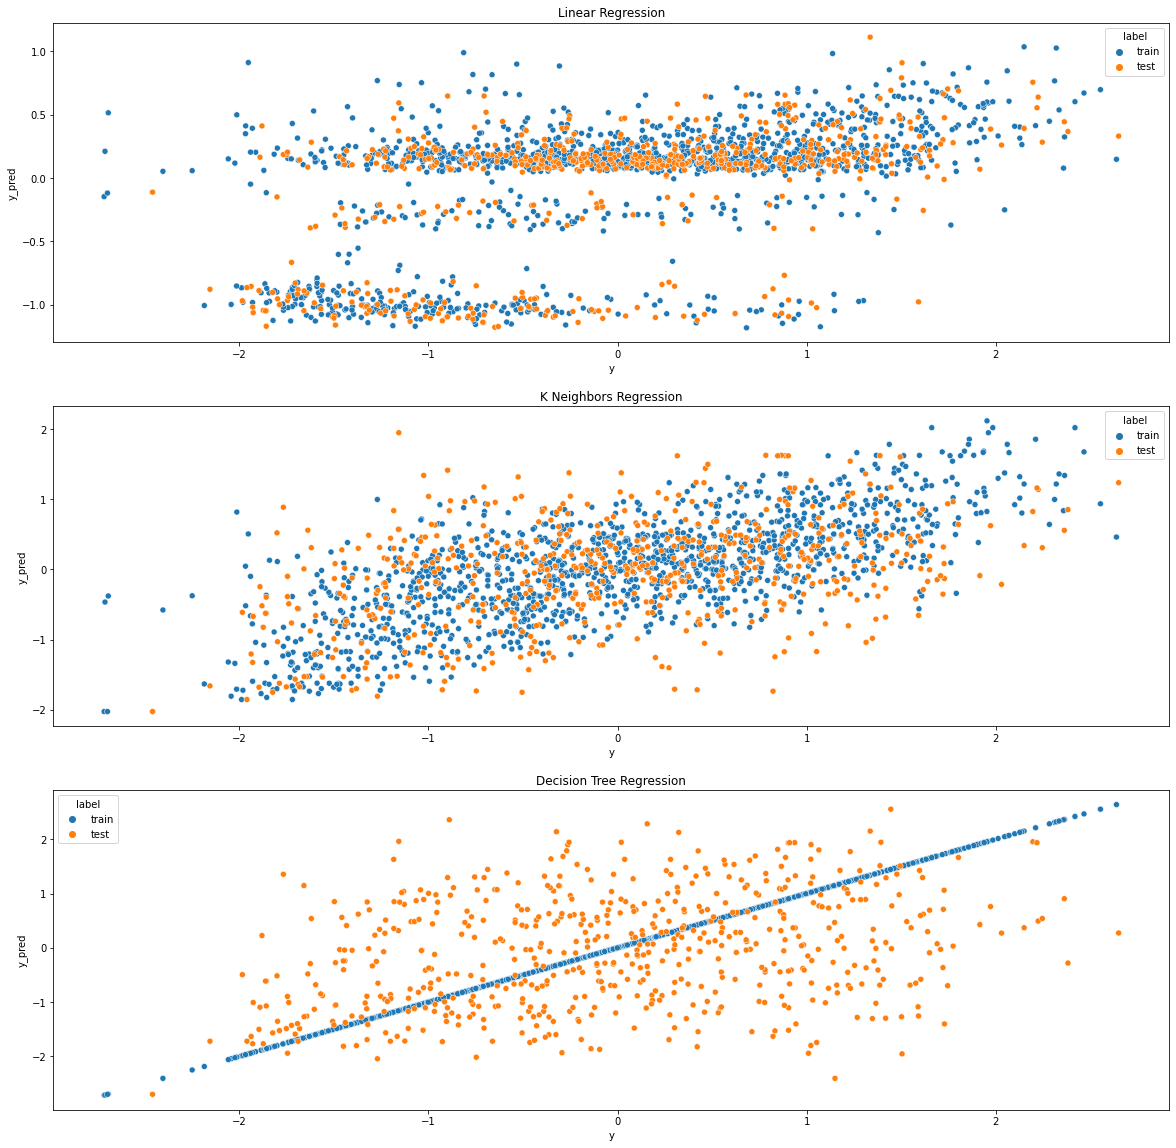

In [9]:
regression("Grooming", trainsize = 0.7, dominant_count = 3);

Lasso |Coefs|:
[0.35951957 0.5001594  0.57002334 0.59968939 0.14957579 0.
 0.25375175 0.         0.         0.         0.03870267 0.        ]
[ 5  7  8  9 11 10  4  6  0  1  2  3]
Selecting 3 Columns:
{'Rejected', 'Single', 'anglesub'}
Linear Regression
	rmse/r2 train =  0.8671883007800321/0.3031615099299222
	rmse/r2 test =  0.6542295723666685/0.37211172216760957
K Neighbors Regression
	rmse/r2 train =  0.7237834495891209/0.5145744773872831
	rmse/r2 test =  0.7626880459042904/0.1466721657699569
Decision Tree Regression
	rmse/r2 train =  0.0/1.0
	rmse/r2 test =  0.9755424313494763/-0.3960930355786936


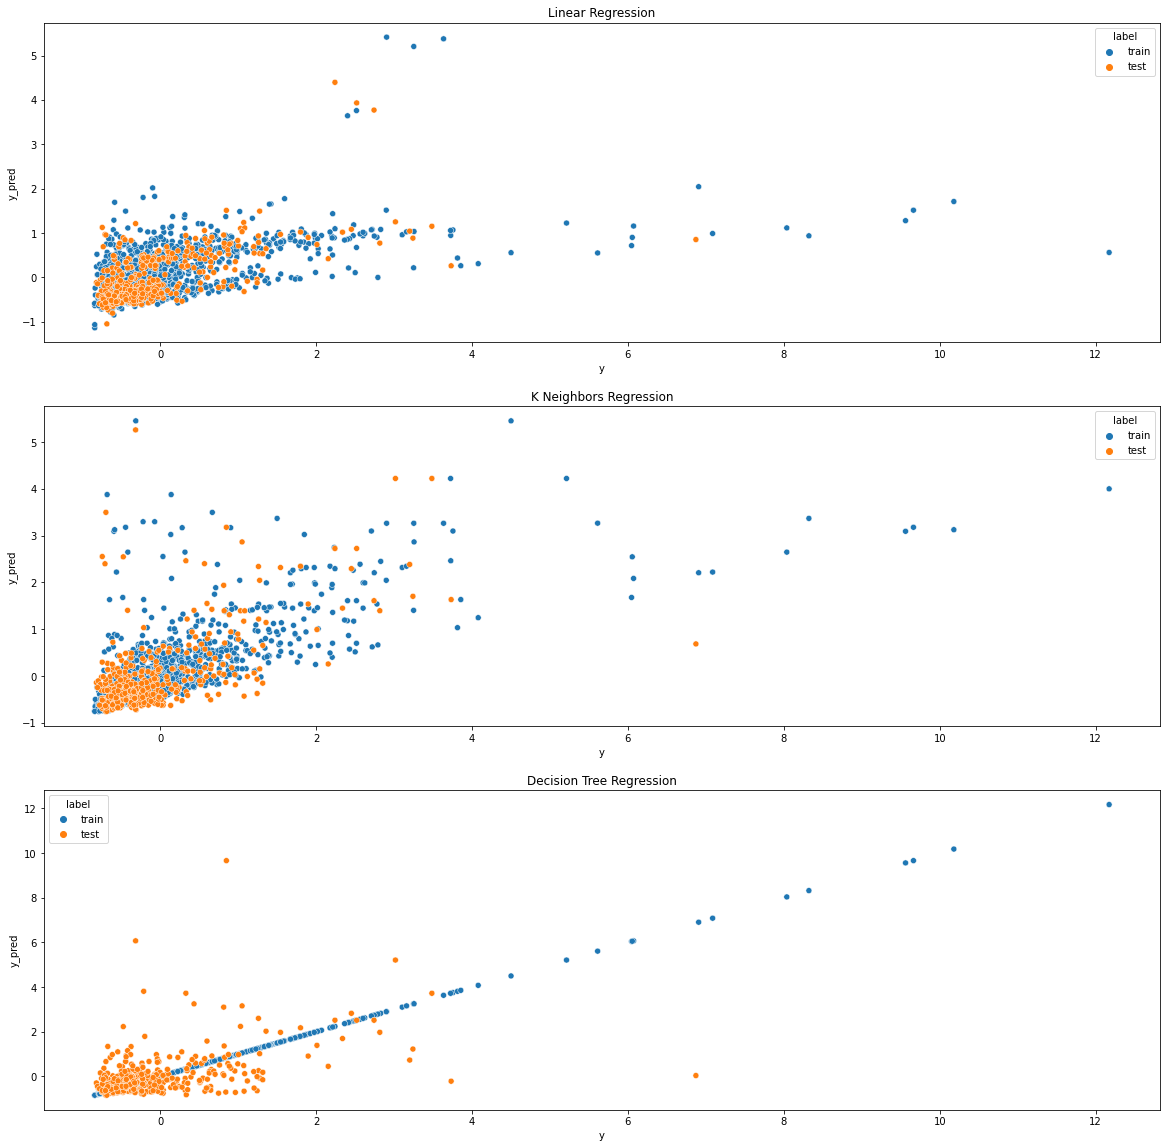

In [10]:
regression("Chase", trainsize = 0.8, dominant_count = 3);

Lasso |Coefs|:
[0.16080562 0.76581072 0.         0.18637803 0.0592669  0.
 0.         0.         0.         0.         0.         0.        ]
[ 2  5  6  7  8  9 10 11  4  0  3  1]
Selecting 3 Columns:
{'Rejected', 'Single', 'anglesub'}
Linear Regression
	rmse/r2 train =  0.5194074393656162/0.7339574952174535
	rmse/r2 test =  0.42657766480467324/0.7906997052278648
K Neighbors Regression
	rmse/r2 train =  0.3842164632045779/0.8544250543704082
	rmse/r2 test =  0.44690569006488146/0.7702765216914339
Decision Tree Regression
	rmse/r2 train =  0.0/1.0
	rmse/r2 test =  0.6129689103196451/0.5678340854979539


(LinearRegression(),
 KNeighborsRegressor(n_neighbors=3),
 DecisionTreeRegressor(),
 ['Rejected', 'Single', 'anglesub'])

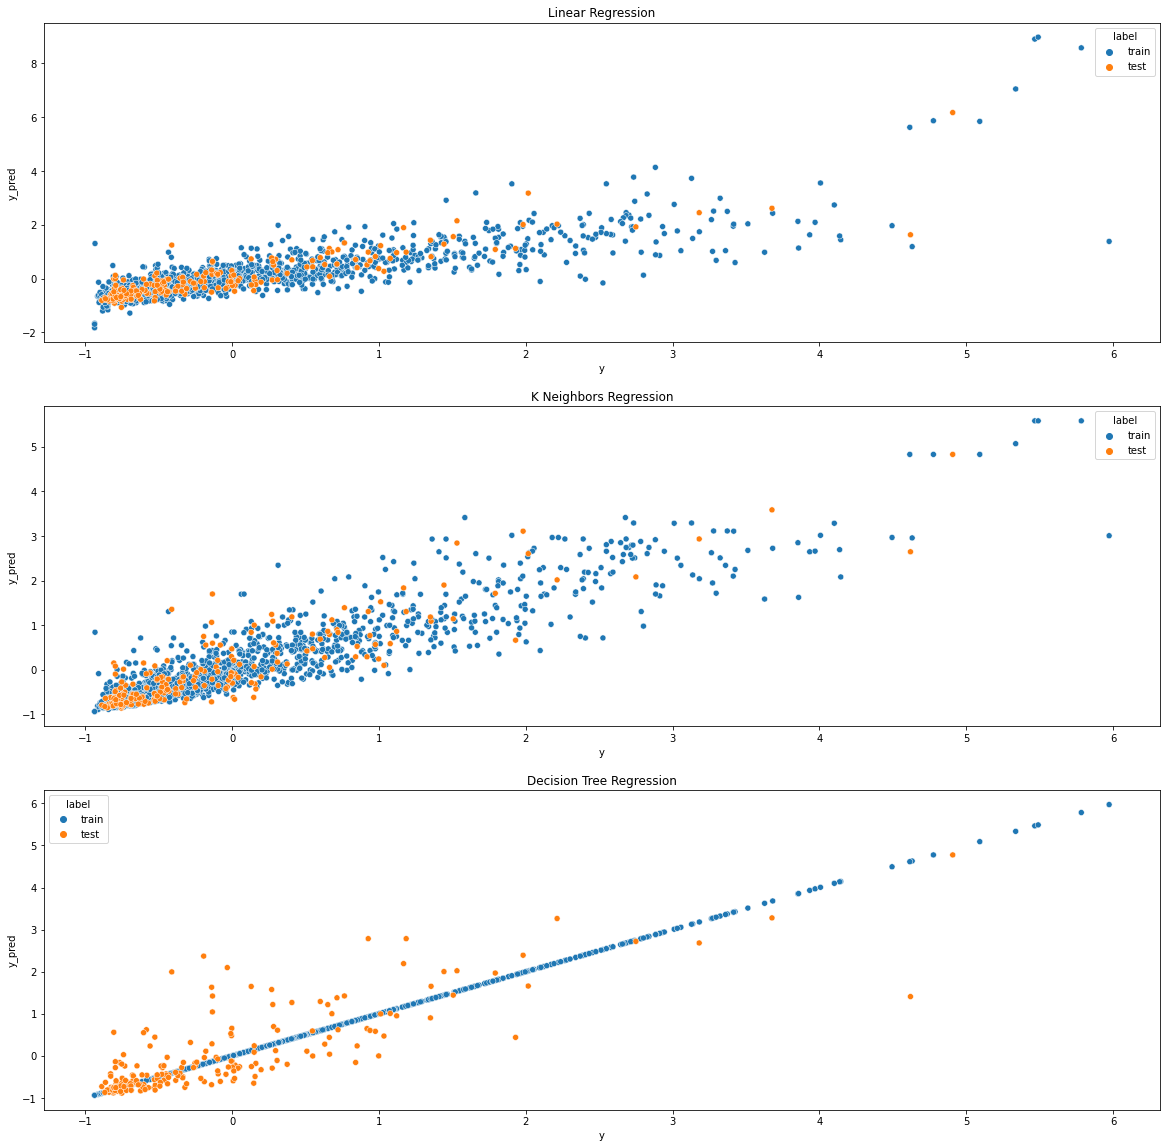

In [11]:
regression("Chain", trainsize = 0.9, dominant_count = 3)

Lasso |Coefs|:
[0.         0.02677731 0.75436713 0.         0.         0.07830655
 0.02533363 0.         0.         0.22223288 0.         0.        ]
[ 0  3  4  7  8 10 11  6  1  5  9  2]
Selecting 3 Columns:
{'Rejected', 'Single', 'anglesub'}


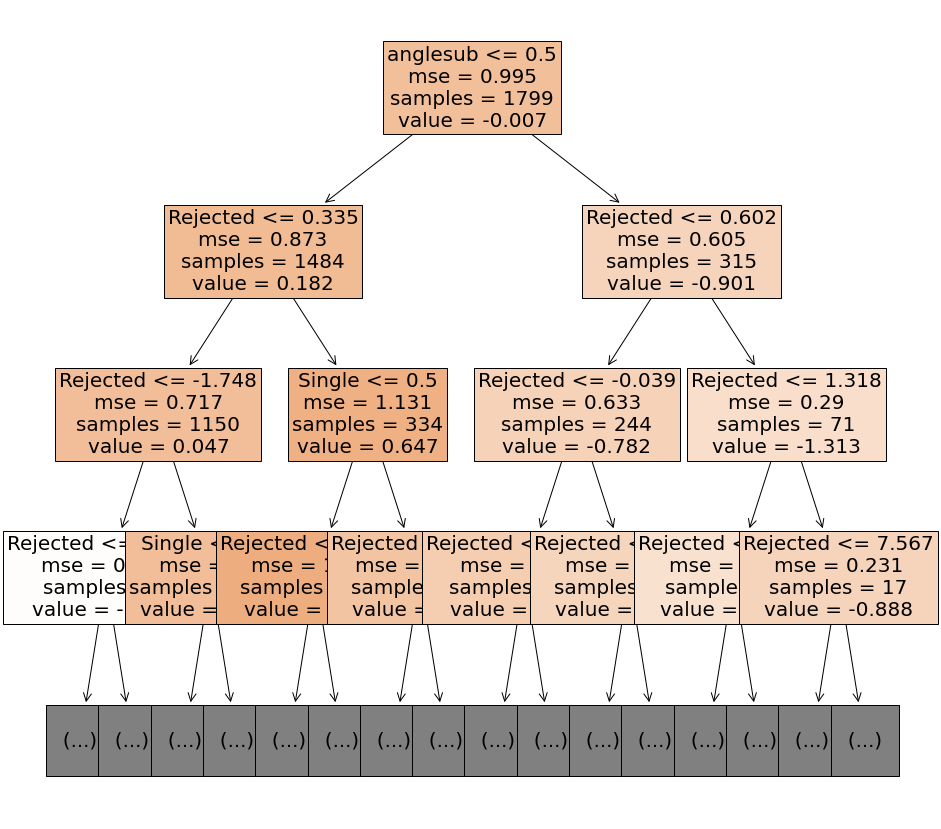

In [12]:
(lr, knr, dtr, features) = regression("Grooming", trainsize = 0.9, dominant_count = 3, scatter_plot = False)

#tree output that does not require graphviz
plt.figure(figsize = (15, 15))
tree.plot_tree(dtr, max_depth = 3, feature_names = features, filled = True, fontsize = 20);